In [10]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

from scipy.optimize import minimize
from scipy.stats import poisson

import torch
import torch.nn.functional as F

## Fit-based counting algorithm

In [11]:
def gaussian_splash_pytorch(A, sigma, size=3, device='cpu'):
    """Prepare the Gaussian splash as a PyTorch convolution kernel."""
    x = y = torch.arange(0, size, device=device) - (size // 2)
    X, Y = torch.meshgrid(x, y)
    gaussian = A * torch.exp(- (X**2 + Y**2) / (2 * sigma**2))
    # Reshape to 4D tensor: (out_channels, in_channels, height, width)
    gaussian_kernel = gaussian.unsqueeze(0).unsqueeze(0)
    return gaussian_kernel

def construct_modeled_frame_pytorch(frame_ct, splash_kernel, noise_sigma, device='cpu'):
    """Construct the modeled frame using convolution to apply the Gaussian splash."""
    # Ensure frame_ct is a float tensor and add batch and channel dimensions
    frame_ct_tensor = frame_ct.float().unsqueeze(1)
    
    # Apply the Gaussian splash across the entire frame using convolution
    modeled_frame = F.conv2d(frame_ct_tensor, splash_kernel, padding=splash_kernel.shape[-1]//2)
    
    # Add noise
    #modeled_frame = modeled_frame + torch.normal(0, noise_sigma, size=frame.shape, device=device)
    
    # Remove batch and channel dimensions from the output
    modeled_frame = modeled_frame.squeeze(1)
    
    return modeled_frame

def count_frame_pytorch(frame_bls, frame_ct, n_steps_max=5000, loss_lim = 1):
    """Counts a frame given initial guess frame_ct"""
    
    # Convert frame and frame_ct to a PyTorch tensor
    frame_tensor = torch.from_numpy(frame_bls).to(device)
    frame_ct_tensor = torch.tensor(frame_ct, dtype=torch.float32, device=device, requires_grad=True)

    # Define the optimizer
    optimizer = torch.optim.Adam([frame_ct_tensor], lr=0.01)

    # Define the single-electron Gaussian splash
    splash = gaussian_splash_pytorch(A,sigma,device=device)

    # Set up the parameters for the iteration
    n_steps = 0
    loss = loss_lim + 1
    
    while(loss > loss_lim and n_steps < n_steps_max):
        
        optimizer.zero_grad()  # Clear previous gradients

        # Construct the modeled frame
        modeled_frame = construct_modeled_frame_pytorch(frame_ct_tensor, splash, noise_sigma, device=device)

        # Compute the loss (negative likelihood)
        loss = torch.sum((frame_tensor - modeled_frame) ** 2)

        # Compute gradients
        loss.backward()

        # Update frame_ct_tensor based on gradients
        optimizer.step()

        n_steps += 1
        if(n_steps >= n_steps_max):
            print(f"Warning, stopping at max steps {n_steps} with loss {loss}")
        if n_steps % 10 == 0:
           print(f"Step {n_steps}, Loss: {loss.item()}")
    print(f"Counted in n_steps = {n_steps} with loss = {loss}")
    
    return frame_ct_tensor.cpu().detach().numpy(), modeled_frame.cpu().detach().numpy()

def frame_to_indices_weights(counted_frames):
    """Convert a batch of 2D counted frames into lists of linear indices and weights."""
    batch_size = counted_frames.shape[0]
    frame_shape = counted_frames.shape[1:]
    all_linear_indices = []
    all_weights = []

    for i in range(batch_size):
        frame = counted_frames[i]
        nonzero_indices = np.nonzero(frame)
        weights = frame[nonzero_indices]
        linear_indices = np.ravel_multi_index(nonzero_indices, frame_shape)
        
        all_linear_indices.append(linear_indices)
        all_weights.append(weights)

    return all_linear_indices, all_weights

def update_counted_data_hdf5(file_path, batch_start_idx, frames_indices, frames_weights, group_name='electron_events'):
    # Ensure frames_indices and frames_weights are lists of arrays, 
    # with each array corresponding to one frame's data.
    
    with h5py.File(file_path, 'a') as f:  # Open file in append mode
        # Create or access the group
        if group_name not in f:
            grp = f.create_group(group_name)
        else:
            grp = f[group_name]

        # Check if the VL datasets exist, create them if not
        if 'frames' not in grp:
            vl_dtype_indices = h5py.special_dtype(vlen=np.dtype('int32'))
            vl_dataset_indices = grp.create_dataset("frames", (16512,), dtype=vl_dtype_indices)
        else:
            vl_dataset_indices = grp['frames']

        if 'weights' not in grp:
            vl_dtype_weights = h5py.special_dtype(vlen=np.dtype('int32'))
            vl_dataset_weights = grp.create_dataset("weights", (16512,), dtype=vl_dtype_weights)
        else:
            vl_dataset_weights = grp['weights']

        # Assuming the length of frames_indices matches the expected number of frames,
        # iterate through each and update the datasets
        for i, (indices, weights) in enumerate(zip(frames_indices, frames_weights)):
            vl_dataset_indices[batch_start_idx+i] = indices
            vl_dataset_weights[batch_start_idx+i] = weights
            
def compute_conditional_probabilities(lam_grid):
    """
    Compute the array of conditional probabilities P(n >= 2) / P(n >= 1) for a grid of lambda values.
    
    :param lam_grid: A 576x576 numpy array of lambda values.
    :return: A 576x576 numpy array of conditional probabilities.
    """
    # Compute P(n >= 1) and P(n >= 2) for each lambda in the grid
    p_at_least_1 = 1 - poisson.cdf(0, lam_grid)  # P(n >= 1) = 1 - P(n < 1)
    p_at_least_2 = 1 - poisson.cdf(1, lam_grid)  # P(n >= 2) = 1 - P(n <= 1)
    
    # Conditional probability P(n >= 2) / P(n >= 1)
    # Safeguard division by zero by using np.where to only compute valid divisions
    conditional_prob = np.where(p_at_least_1 > 0, p_at_least_2 / p_at_least_1, 0)
    
    return conditional_prob

In [3]:
# Initial variables
dataset_path = "/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan0000001546.h5"
counted_data_path = "counted_scan0000001546.h5"
A = 19.032279882831432
sigma = 0.5065158792172835
noise_sigma = 1.0
device='cuda'
nframes = 16512
frame_width = 576
nbatch = 2064
baseline = 20.0
th_single_elec = 10

In [4]:
# Create the "prior"
with h5py.File(dataset_path, 'r') as f0:
    data = f0['frames']
    
    # Get all frames and subtract the baseline.
    prior_bls = np.array(data[:,:,:],dtype=np.float32) - baseline
    
# Compute the summed frame.
prior_frame = np.sum(prior_bls,axis=0)

# Divide by the average electron amplitude.
prior_frame /= A

# Normalize by the number of frames to get the final "prior".
prior_frame /= nframes

# Eliminate negative values.
prior_frame[prior_frame < 0] = 0.

# Compute the conditional probabilities of having >= 2 counts, given >= 1 count.
conditional_prob = compute_conditional_probabilities(prior_frame)

In [18]:
conditional_prob[200:300,200:300]

array([[0.16994316, 0.18837841, 0.19053846, ..., 0.18347743, 0.17425726,
        0.19169732],
       [0.19837859, 0.21074929, 0.19784166, ..., 0.19534903, 0.20621606,
        0.17636312],
       [0.19474214, 0.18643654, 0.19791682, ..., 0.18607345, 0.19861077,
        0.19228249],
       ...,
       [0.21982849, 0.20365499, 0.20269069, ..., 0.17307934, 0.17951822,
        0.17447765],
       [0.19467089, 0.19458044, 0.17790628, ..., 0.19325575, 0.18757199,
        0.19614447],
       [0.18063555, 0.20169968, 0.21381144, ..., 0.17899043, 0.17584084,
        0.17265059]])

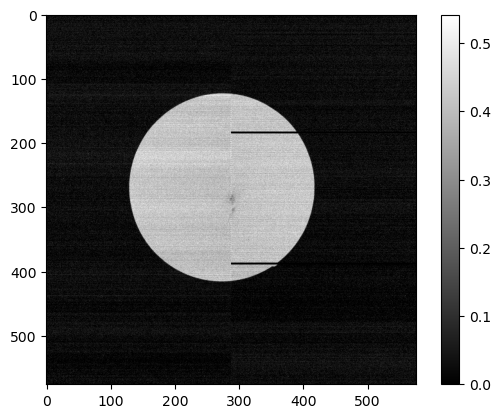

In [16]:
# Plot the prior
iprior = plt.imshow(prior_frame, vmin=prior_frame.min(), vmax=prior_frame.max(), cmap='gray')
plt.colorbar()
#axs[i].set_title(f'Scan No: {scan_no}')

In [ ]:
batches = round(nframes / nbatch)
print(f"Analyzing in {batches} batches...")
for batch in range(batches):
    print(f"\n\n ** BATCH {batch} **")
    
    # Get the frames for this batch
    print("-- Processing frames...")
    with h5py.File(dataset_path, 'r') as f0:
        data = f0['frames']

        # Get the frames
        frame_bls = np.array(data[batch*nbatch:batch*nbatch+nbatch,:,:],dtype=np.float32) - baseline

        # Compute an initial counted frame
        frame_ct = np.rint(frame_bls / A, out=np.zeros(frame_bls.shape,dtype=np.int16), casting='unsafe')
        frame_ct[frame_ct < th_single_elec] = 0

    # Count the frames.
    print("-- Counting frames...")
    frame_ct_reco, modeled_frame_reco = count_frame_pytorch(frame_bls, frame_ct, n_steps_max = 1000, loss_lim = nframes)
    frame_ct_reco[frame_ct_reco < 0] = 0
    frame_ct_reco = np.rint(frame_ct_reco)
    
    # Apply the prior for each frame.
    
    # Save the counted frames in the array
    print("-- Saving frames...")
    frames_indices, frames_weights = frame_to_indices_weights(frame_ct_reco)
    print(f"Frame indices len = {len(frames_indices)} and weights = {len(frames_weights)}")
    update_counted_data_hdf5(counted_data_path, batch*nbatch, frames_indices, frames_weights)

### Counting analysis

In [ ]:
# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols

# Function to create a 2D image from the counted frame data
def create_counted_image_weighted(frame_data, weight_data, frame_height, frame_width):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    for r,c,w in zip(rows,cols,weight_data):
        image[r, c] = w

    return image

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def calculate_center_of_mass(counted_image):
    """Calculate the center of mass of the counted image."""
    total_mass = np.sum(counted_image)
    indices = np.indices(counted_image.shape)
    mean_x = np.sum(indices[1] * counted_image) / total_mass
    mean_y = np.sum(indices[0] * counted_image) / total_mass
    sigma_x = np.sqrt(np.sum((indices[1] - mean_x)**2 * counted_image) / total_mass)
    sigma_y = np.sqrt(np.sum((indices[0] - mean_y)**2 * counted_image) / total_mass)
    return mean_x, mean_y, sigma_x, sigma_y

def cartesian_to_polar_counts(image, center=None):
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)  # Use the middle of the image
    
    y, x = np.indices(image.shape)
    x = x - center[0]
    y = y - center[1]
    
    # Convert Cartesian coordinates to polar
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    # Convert theta from radians to degrees
    theta = np.degrees(theta)
    theta[theta < 0] += 360  # Convert negative angles to positive angles
    
    return r, theta, image

def plot_counts_vs_angle_binned(image, target_radius, center=None, delta_radius=5, num_bins=360):
    r, theta, counts = cartesian_to_polar_counts(image, center)
    
    # Find indices where radius is close to target radius
    mask = (r >= target_radius - delta_radius) & (r <= target_radius + delta_radius)
    actual_radius = np.mean(r[mask])

    # Bin the theta values
    bins = np.linspace(0, 360, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    digitized = np.digitize(theta[mask], bins) - 1  # Indices of the bins to which each value belongs

    # Aggregate counts in each bin
    binned_counts = np.zeros(num_bins)
    np.add.at(binned_counts, digitized, counts[mask])  # Sum counts falling into each bin

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, binned_counts, marker='o', linestyle='-', color='b')
    plt.title(f'Count Distribution Near Radius ~{actual_radius:.2f}')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.show()

In [ ]:
scan_groups = [ [1531],
               [1531, 1532, 1533, 1534],  # 70 pA, 300 kV, 30 mrad
               [1535, 1536, 1537, 1538],  # 140 pA
               [1539, 1540, 1541, 1542],  # 280 pA
               [1543, 1544, 1545, 1546]]  # 560 pA
clength = [68, 54, 43, 34]  # in mm
idbase = [12284, 12288, 12292, 12296]
nframes = 16512
frame_width = 576
with_weights = True

# Centers and radii for circular areas
center_pixels = [(280,277.5), (267.5,275), (282.5,288), (271,273)]
radii = [265]
#radii = [285, 233, 185, 149]

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# Set up lists for storing analysis information
counted_electrons, counted_nelec = [], []
counted_circle_electrons = []
mean_x_lists, mean_y_lists, sigma_x_lists, sigma_y_lists = [], [], [], []

igroup = 0
for i, scan_no in enumerate(scan_groups[igroup]):
    print(f"Processing scan {scan_no}...")
    file_path = f"counted_scan000000{scan_no}.h5"
    #file_path = f"/global/cfs/cdirs/ncemhub/distiller/counted/2023.09.18/data_scan{scan_no}_id{idbase[igroup]+i}_electrons.h5"
    with h5py.File(file_path, 'r') as f0:
        
        # Create the circular mask
        center = center_pixels[i]
        radius = radii[i]
        mask = create_circular_mask(frame_width, frame_width, center=center, radius=radius)

        summed_counted_image = np.zeros((frame_width, frame_width), dtype=np.int32)
        summed_circle_counted_image = np.zeros((frame_width, frame_width), dtype=np.int32)
        
        # Create lists for CM computations.
        mean_x_list, mean_y_list, sigma_x_list, sigma_y_list = [], [], [], []
        
        nelec = 0
        for iframe in range(nframes):
            #if(iframe % int(nframes/10) == 0):
            #    print(f"Processing frame {iframe}/{nframes}")
            frame_data = np.array(f0['electron_events']['frames'][iframe])
            if(with_weights):
                weight_data = np.array(f0['electron_events']['weights'][iframe])
            else:
                weight_data = np.ones(len(f0['electron_events']['frames'][iframe]))

            # Create a 2D image of the counted frame
            counted_image = create_counted_image_weighted(frame_data, weight_data, frame_width, frame_width)
            
            # Compute center of mass quantities for the counted image
            mean_x, mean_y, sigma_x, sigma_y = calculate_center_of_mass(counted_image)

            # Append CoM data to lists
            mean_x_list.append(mean_x)
            mean_y_list.append(mean_y)
            sigma_x_list.append(sigma_x)
            sigma_y_list.append(sigma_y)

            # Sum the counted images
            summed_counted_image += counted_image
            nelec += len(frame_data)
            
            # Apply the mask and sum the pixel values within the circle
            masked_image = counted_image * mask
            summed_circle_counted_image += masked_image
            
        # Save the lists
        mean_x_lists.append(mean_x_list)
        mean_y_lists.append(mean_y_list)
        sigma_x_lists.append(sigma_x_list)
        sigma_y_lists.append(sigma_y_list)
            
        # Sum all the counts.
        total_counts = np.sum(summed_counted_image)
        circle_counts = np.sum(summed_circle_counted_image)
        background_counts = total_counts - circle_counts
        print(f"-- Total counts: {total_counts}")
        print(f"-- Total counts in circle: {circle_counts}")
        print(f"-- Background counts: {background_counts} ({background_counts/total_counts*100:.2f}%)")
        print(f"-- Total nelec:  {nelec}")
        counted_electrons.append(total_counts)
        counted_circle_electrons.append(circle_counts)
        counted_nelec.append(nelec)

        # Plot the summed, counted image
        imax = axs[i].imshow(summed_counted_image, vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='gray')
        #imax = axs[i].imshow(summed_counted_image[200:250,200:250], vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='grey')

        # Add a circle to the plot to indicate the mask region
        circle = Circle(center, radius, color='red', fill=False, linewidth=1.5)
        axs[i].add_patch(circle)

        fig.colorbar(imax, ax=axs[i])
        axs[i].set_title(f'Scan No: {scan_no}')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.figure(figsize=(8, 6))  # Figure for the sum vs. camera length plot
plt.plot(clength, counted_electrons, marker='o', linestyle='-',label="Counted electrons")
plt.plot(clength, counted_nelec, marker='o', linestyle='--',label="Counted pixels")
plt.plot(clength, counted_circle_electrons, marker='*', linestyle='--',label="Counted in circle")
plt.xlabel('Camera length (mm)')
plt.ylabel('Sum of all counted electrons')
plt.grid(True)
plt.legend()

In [ ]:
# Histogram of mean x positions
plt.figure()
plt.hist(mean_x_lists[0], bins=50, alpha=0.75, label=f"clength = {clength[0]}")
plt.hist(mean_x_lists[1], bins=50, alpha=0.75, label=f"clength = {clength[1]}")
plt.hist(mean_x_lists[2], bins=50, alpha=0.75, label=f"clength = {clength[2]}")
plt.hist(mean_x_lists[3], bins=50, alpha=0.75, label=f"clength = {clength[3]}")
#plt.title('Mean X Positions')
plt.xlabel('Mean X')
plt.ylabel('Counts/bin')
plt.legend()

# Histogram of mean y positions
plt.figure()
plt.hist(mean_y_lists[0], bins=50, alpha=0.75, label=f"clength = {clength[0]}")
plt.hist(mean_y_lists[1], bins=50, alpha=0.75, label=f"clength = {clength[1]}")
plt.hist(mean_y_lists[2], bins=50, alpha=0.75, label=f"clength = {clength[2]}")
plt.hist(mean_y_lists[3], bins=50, alpha=0.75, label=f"clength = {clength[3]}")
#plt.title('Mean Y Positions')
plt.xlabel('Mean Y')
plt.ylabel('Counts/bin')
plt.legend()

In [ ]:
plot_counts_vs_angle_binned(summed_counted_image, target_radius=265, center=(280, 277.5))  # adjust radius and center as needed

In [ ]:
file_path = f"/global/cfs/cdirs/ncemhub/distiller/counted/2023.09.18/data_scan1531_id12284_electrons.h5"
with h5py.File(file_path, 'r') as f0:
    frame_data = np.array(f0['electron_events']['frames'][2])
    print(f0['electron_events']['frames'])
    print(frame_data.shape)

In [ ]:
with h5py.File("counted_scan0000001532.h5", 'r') as f0:
    frame_data = np.array(f0['electron_events']['frames'][16505])
    print(f0['electron_events']['frames'])
    print(frame_data)
    print(len(frame_data))

Create the initial prediction for the counted frame

In [ ]:
nreco = 0

with h5py.File(dataset_path, 'r') as f0:
    data = f0['frames']
    
    # Get the frame
    frame_bls = np.array(data[nreco:nreco+nframes,:,:],dtype=np.float32) - baseline
    
    # Subtract the baseline
    #frame_bls = (frame - baseline)
    
    # Get a "prior" counted frame
    #frame_ct = (frame - baseline)
    frame_ct = np.rint(frame_bls / A, out=np.zeros(frame_bls.shape,dtype=np.int16), casting='unsafe')
    frame_ct[frame_ct < th_single_elec] = 0


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

# Plotting on the ith subplot
ax0 = axs[0].imshow(frame_bls[0], vmin=frame_bls[0].min(), vmax=frame_bls[0].max())
fig.colorbar(ax0, ax=axs[0])
ax1 = axs[1].imshow(frame_ct[0], vmin=frame_ct[0].min(), vmax=frame_ct[0].max())
fig.colorbar(ax1, ax=axs[1])

# Print nonzero prior values
#print("Nonzero values in frame_ct:")
#print(frame_ct[np.nonzero(frame_ct)])
#np.sum(frame_ct[np.nonzero(frame_ct)])

Perform the fit

In [ ]:
frame_ct_reco, modeled_frame_reco = count_frame_pytorch(frame_bls, frame_ct, n_steps_max = 500, loss_lim = nframes)

In [ ]:
plt.imshow(modeled_frame_reco[0][100:150,100:150])

In [ ]:
frame_ct_reco[frame_ct_reco < 0] = 0
frame_ct_reco = np.rint(frame_ct_reco)

In [ ]:
nframe = 0
rng_start, rng_end = 150, 200

# Set up the figure
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs = axs.flatten()

frame_plt = frame_bls

ax0 = axs[0].imshow(frame_plt[nframe,rng_start:rng_end,rng_start:rng_end], vmin=frame_plt[nframe,rng_start:rng_end,rng_start:rng_end].min(), vmax=frame_plt[nframe,rng_start:rng_end,rng_start:rng_end].max())
fig.colorbar(ax0, ax=axs[0])
axs[0].set_title("Frame (baseline subtracted)")
ax1 = axs[1].imshow(frame_ct_reco[nframe,rng_start:rng_end,rng_start:rng_end], vmin=frame_ct_reco[nframe,rng_start:rng_end,rng_start:rng_end].min(), vmax=frame_ct_reco[nframe,rng_start:rng_end,rng_start:rng_end].max())
fig.colorbar(ax1, ax=axs[1])
axs[1].set_title("Reconstructed counts")
ax2 = axs[2].imshow(frame_ct[nframe,rng_start:rng_end,rng_start:rng_end], vmin=frame_ct[nframe,rng_start:rng_end,rng_start:rng_end].min(), vmax=frame_ct[nframe,rng_start:rng_end,rng_start:rng_end].max())
fig.colorbar(ax2, ax=axs[2])
axs[2].set_title("Prior counts")

print(f"Total counts reco = {np.sum(frame_ct_reco[nframe,rng_start:rng_end,rng_start:rng_end])}, prior = {np.sum(frame_ct[nframe,rng_start:rng_end,rng_start:rng_end])}")

In [ ]:
#np.unique(frame_ct_reco[np.nonzero(frame_ct_reco)])
np.unique(frame_ct[np.nonzero(frame_ct)])

# Get single-electron Gaussian profile

In [ ]:
def randomized_scan_order(nrows, ncols):
    indices = [(i, j) for i in range(1, nrows-1) for j in range(1, ncols-1)]
    np.random.shuffle(indices)
    return indices

def extract_3x3_patches(original_frames, processed_frames):
    """
    Extract 3x3 patches from original frames based on hits identified in processed frames.
    
    Args:
    - original_frames: numpy array of original frames (non-baseline-subtracted, non-thresholded).
    - processed_frames: numpy array of frames after baseline subtraction and thresholding.
    
    Returns:
    - numpy array of 3x3 patches centered around identified hits.
    """
    hit_patches = []
    nrows, ncols = processed_frames.shape[1], processed_frames.shape[2]  # Frame dimensions

    for frame_index in range(processed_frames.shape[0]):
        processed_frame = processed_frames[frame_index]
        original_frame = original_frames[frame_index]
        
        # Iterate through all pixels in the processed frame to find hits
        indices = randomized_scan_order(nrows, ncols)
        for i, j in indices:
            if processed_frame[i, j] > 0:  # Center of a hit in processed frame
                
                # Extract the corresponding 3x3 patch from the original frame
                patch = original_frame[i-1:i+2, j-1:j+2]
                hit_patches.append(patch)

    return np.array(hit_patches)

In [ ]:
base_dir = "/Users/jrenner/temp/lbl"
scan_no = 1531
nframes = 1000 #16512
frame_width = 576
baseline = 20.0
th_single_elec = 10

print(f"Processing scan {scan_no}...")
file_path = f"{base_dir}/data_scan000000{scan_no}.h5"
with h5py.File(file_path, 'r') as f0:
    data = f0['frames']
    frames = data[0:nframes, :, :]
    
    # Subtract baseline only.
    sub_frames = (frames - baseline)

    # Subtract the baseline and threshold.
    sub_frames_th = (frames - baseline)
    sub_frames_th[sub_frames < th_single_elec] = 0

    # Extract the 3x3 Gaussian pattern
    hit_patches = extract_3x3_patches(sub_frames, sub_frames_th)
    
    avg_patch = np.mean(hit_patches, axis=0)

    # Plot the averaged Gaussian
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    imax = ax.imshow(avg_patch, vmin=avg_patch.min(), vmax=avg_patch.max(), cmap='jet')
    fig.colorbar(imax, ax=ax)
    print(avg_patch)

In [ ]:
# The average 3x3 single-electron matrix
matrix = np.array(avg_patch)

# Gaussian function (assuming isotropic and centered at (1,1))
def gaussian(x, y, A, sigma):
    return A * np.exp(-((x-1)**2 + (y-1)**2) / (2*sigma**2))

# Objective function to minimize (MSE)
def objective(params):
    A, sigma = params
    predicted = np.array([[gaussian(x, y, A, sigma) for y in range(3)] for x in range(3)])
    return np.mean((matrix - predicted)**2)

# Initial guesses for A and sigma
initial_guess = [19, 0.5]

# Perform the optimization
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0, None), (0, None)])

# Optimized parameters
A_opt, sigma_opt = result.x
print(f"Optimized A: {A_opt}, Optimized sigma: {sigma_opt}")

In [ ]:
# Generate the optimized Gaussian 3x3 matrix
optimized_patch = np.array([[gaussian(x, y, A_opt, sigma_opt) for y in range(3)] for x in range(3)])

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original averaged patch
axs[0].imshow(avg_patch, cmap='viridis')
axs[0].set_title('Original Avg. Patch')
axs[0].axis('off')

# Optimized Gaussian patch
axs[1].imshow(optimized_patch, cmap='viridis')
axs[1].set_title('Optimized Gaussian Patch')
axs[1].axis('off')

# Difference
axs[2].imshow(avg_patch - optimized_patch, cmap='viridis')
axs[2].set_title('Difference (Original - Optimized)')
axs[2].axis('off')

plt.show()

# Print optimized Gaussian
print(optimized_patch)

In [ ]:
# Look at histogram of some frames
nframes = 10
file_path = f"/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan000000{scan_no}.h5"
with h5py.File(file_path, 'r') as f0:
    data = f0['frames']
    
    data_hist = np.array(data[0:nframes,:,:],dtype=np.float32) - 20
    
    plt.hist(data_hist.flatten(), bins=100) #, range=[0,20])
    plt.yscale('log')
    plt.xlabel("baseline subtracted (-20) pixel value")

# Attempt to count a single frame

In [ ]:
A = 54.05
sigma = 0.46555
noise_sigma = 1.0

def gaussian_5x5(A, sigma):
    """Generate a 5x5 Gaussian splash."""
    x = y = np.arange(0, 5) - 2  # Centered at 0, 0
    X, Y = np.meshgrid(x, y)
    gaussian = A * np.exp(- (X**2 + Y**2) / (2 * sigma**2))
    return gaussian

# Construct the 5x5 Gaussian
gaus_elec = gaussian_5x5(A, sigma)

Obtain the frame to be counted

In [ ]:
nreco = 0
baseline = 20.0
th_single_elec = 10

file_path = f"/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan000000{scan_no}.h5"
with h5py.File(file_path, 'r') as f0:
    data = f0['frames']
    
    # Get the frame
    frame = np.array(data[nreco,:,:],dtype=np.float32)
    
    # Get a "prior" counted frame
    frame_ct = (frame - baseline)
    frame_ct[frame_ct < th_single_elec] = 0
    frame_ct = np.rint(frame_ct / A)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

# Plotting on the ith subplot
ax0 = axs[0].imshow(frame, vmin=frame.min(), vmax=frame.max())
fig.colorbar(ax0, ax=axs[0])
ax1 = axs[1].imshow(frame_ct, vmin=frame_ct.min(), vmax=frame_ct.max())
fig.colorbar(ax1, ax=axs[1])

# Print nonzero prior values
print("Nonzero values in frame_ct:")
print(frame_ct[np.nonzero(frame_ct)])

Construct the modeled frame

In [ ]:
def construct_modeled_frame_from_counts(frame_ct, splash):
    modeled_frame = np.zeros(frame_ct.shape)
    nrows, ncols = frame_ct.shape
    splash_size = splash.shape[0]  # Assuming splash is square

    for x in range(nrows):
        for y in range(ncols):
            count = frame_ct[x, y]
            if count > 0:
                # Determine the indices for adding the splash
                x_start = max(0, x - splash_size // 2)
                x_end = min(nrows, x + splash_size // 2 + 1)
                y_start = max(0, y - splash_size // 2)
                y_end = min(ncols, y + splash_size // 2 + 1)
                
                # Adjust splash dimensions if near edges
                splash_x_start = 0 - min(0, x - splash_size // 2)
                splash_y_start = 0 - min(0, y - splash_size // 2)
                splash_x_end = splash.shape[0] + min(0, nrows - (x + splash_size // 2 + 1))
                splash_y_end = splash.shape[1] + min(0, ncols - (y + splash_size // 2 + 1))
                #print(f"x from {x_start} to {x_end}")
                #print(f"splash from {splash_x_start} to {splash_x_end}")

                # Add the splash for each count
                modeled_frame[x_start:x_end, y_start:y_end] += splash[splash_x_start:splash_x_end, splash_y_start:splash_y_end] * count

    return modeled_frame

In [ ]:
modeled_frame = construct_modeled_frame_from_counts(frame_ct, gaus_elec) + np.random.normal(0, noise_sigma, frame.shape)

In [ ]:
plt.hist(modeled_frame.flatten(),bins=100)
plt.yscale('log')

# Creation of averaged frames

In [ ]:
#scan_nos = [1531, 1532, 1533, 1534] # 70 pA
scan_nos = [1543, 1544, 1545, 1546] # 560 pA
nframes = 16512
frame_width = 576
baselines = [20., 20., 20., 20.]
th_single_elec = 30

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, scan_no in enumerate(scan_nos):
    print(f"Processing scan {scan_no}...")
    file_path = f"/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan000000{scan_no}.h5"
    with h5py.File(file_path, 'r') as f0:
        data = f0['frames']
    
        # Subtract the baseline and threshold.
        sub_frames = (data[0:nframes, :, :] - baselines[i])
        sub_frames[sub_frames < th_single_elec] = 0
        
        # Compute the sum of all frames.
        avg_frame = np.average(sub_frames,axis=0)
        
        # Plotting on the ith subplot
        imax = axs[i].imshow(avg_frame, vmin=avg_frame.min(), vmax=avg_frame.max(), cmap='gray')
        fig.colorbar(imax, ax=axs[i])
        axs[i].set_title(f'Scan No: {scan_no}')

---

# Analysis of counted data

In [ ]:
!ls /global/cfs/cdirs/ncemhub/distiller/counted/2023.09.18/
# 1547 is first logo scan

In [ ]:
# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols

# Function to create a 2D image from the counted frame data
def create_counted_image(frame_data, frame_height, frame_width):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    image[rows, cols] = 1

    return image

In [ ]:
scan_groups = [[1531, 1532, 1533, 1534],  # 70 pA, 300 kV, 30 mrad
               [1535, 1536, 1537, 1538],  # 140 pA
               [1539, 1540, 1541, 1542],  # 280 pA
               [1543, 1544, 1545, 1546]]  # 560 pA
clength = [68, 54, 43, 34]  # in mm
idbase = [12284, 12288, 12292, 12296]
nframes = 1
frame_width = 576

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

counted_electrons = []
igroup = 3
for i, scan_no in enumerate(scan_groups[igroup]):
    print(f"Processing scan {scan_no}...")
    file_path = f"/global/cfs/cdirs/ncemhub/distiller/counted/2023.09.18/data_scan{scan_no}_id{idbase[igroup]+i}_electrons.h5"
    with h5py.File(file_path, 'r') as f0:

        summed_counted_image = np.zeros((frame_width, frame_width), dtype=np.int32)
        nelec = 0
        for iframe in range(nframes):
            #if(iframe % int(nframes/10) == 0):
            #    print(f"Processing frame {iframe}/{nframes}")
            frame_data = np.array(f0['electron_events']['frames'][iframe])

            # Create a 2D image of the counted frame
            counted_image = create_counted_image(frame_data, frame_width, frame_width)

            # Sum the counted images
            summed_counted_image += counted_image
            nelec += len(frame_data)
            
        # Sum all the counts.
        print(f"-- Total counts: {np.sum(summed_counted_image)}")
        print(f"-- Total nelec:  {nelec}")
        counted_electrons.append(np.sum(summed_counted_image))

        # Plot the summed, counted image
        imax = axs[i].imshow(summed_counted_image, vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='grey')
        #imax = axs[i].imshow(summed_counted_image[200:250,200:250], vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='grey')
        fig.colorbar(imax, ax=axs[i])
        axs[i].set_title(f'Scan No: {scan_no}')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.figure(figsize=(8, 6))  # Figure for the sum vs. camera length plot
plt.plot(clength, counted_electrons, marker='o', linestyle='-')
plt.xlabel('Camera length (mm)')
plt.ylabel('Sum of all counted electrons')
plt.grid(True)

---

-----

# Analysis of raw data

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [ ]:
scan_nos = [1531, 1532, 1533, 1534]
clength = [60, 54, 43, 34]  # in mm
center_pixels = [(280,280), (270,275), (280,288), (271,273)]
radii = [280, 233, 185, 149]
nframes = 16512
frame_width = 576
#baselines = [20., 20., 20., 20.]
baselines = [20.52008230983527, 20.533552410368216, 20.529735138081396, 20.43255047238372]
sums, means, medians, sigmas = [], [], [], []

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, scan_no in enumerate(scan_nos):
    print(f"Processing scan {scan_no}...")
    file_path = f"/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan000000{scan_no}.h5"
    with h5py.File(file_path, 'r') as f0:
        data = f0['frames']
    
        # Subtract the baseline and threshold.
        sub_frames = (data[0:nframes, :, :] - baselines[i])
        #sub_frames[sub_frames < 30] = 0
        
        # Compute the sum of all frames.
        sum_frame = sub_frames.sum(axis=0)
        
        # Compute the baseline using the sum of all frames.
        new_baseline = sum_frame[-100:,-100:].sum()/(100**2*nframes)
        print(f"-- new computed baseline = {new_baseline}")

        # Create the circular mask
        mask = create_circular_mask(frame_width, frame_width, center=center_pixels[i], radius=radii[i])
        
        # Apply the mask and sum the pixel values
        masked_sum = sum_frame * mask
        circle_sum = masked_sum.sum()
        sums.append(circle_sum)  # Store the sum of the circular area
        #sums.append(sum_frame.sum())  # Store the sum of all pixels
        
        # Apply the mask to each frame and compute individual sums.
        masked_individual_frames = sub_frames*mask
        sum_individual_frames = masked_individual_frames.sum(axis=(1,2))
        means.append(np.mean(sum_individual_frames))
        medians.append(np.median(sum_individual_frames))
        sigmas.append(np.std(sum_individual_frames))

        # Plotting on the ith subplot
        #imax = axs[i].imshow(sum_frame, vmin=sum_frame.min(), vmax=sum_frame.max())
        imax = axs[i].imshow(masked_sum, vmin=sum_frame.min(), vmax=sum_frame.max())
        fig.colorbar(imax, ax=axs[i])
        axs[i].set_title(f'Scan No: {scan_no}')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.figure(figsize=(8, 6))  # Figure for the sum vs. camera length plot
plt.plot(radii, sums, marker='o', linestyle='-')
#plt.xlabel('Camera Length (mm)')
plt.xlabel('Radius of integration area (pixels)')
plt.ylabel('Sum of All Pixels')
plt.grid(True)

plt.figure(figsize=(8, 6))  # Figure for the means
#plt.errorbar(radii, means, yerr=np.sqrt(means), marker='o', linestyle='-')
plt.plot(radii, means, marker='o', linestyle='-', color='blue', label='Mean')
plt.plot(radii, medians, marker='o', linestyle='-', color='green', label='Median')
plt.legend()
#plt.xlabel('Camera Length (mm)')
plt.xlabel('Radius of integration area (pixels)')
plt.ylabel('Mean/median pixel sum in each frame')
plt.grid(True)

plt.show()

---

In [ ]:
# Create the "prior"
with h5py.File(dataset_path, 'r') as f0:
    data = f0['frames']
    
    # Get all frames and subtract the baseline.
    prior_bls = np.array(data[:,:,:],dtype=np.float32) - baseline
    
    # Compute the summed frame.
    prior_frame = np.sum(prior_bls,axis=0)
    
    # Divide by the average electron amplitude.
    prior_frame /= A

---

### Test one scan

In [ ]:
scan_no = 1533
nframes = 16512
file_path = f"/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18/data_scan000000{scan_no}.h5"
f0 = h5py.File(file_path, 'r')
data = f0['frames']

initial_data = data[0:1000, :, :].sum(axis=0)
fg1, axes = plt.subplots(2, 2)
imax1 = axes[0,0].imshow(initial_data, vmin=initial_data[0:288,:].min(), vmax=initial_data[50:-50, 50:-50].max())
plt.colorbar(imax1)